GAN tutorial 따라하기 :: https://www.tensorflow.org/tutorials/generative/dcgan </br>
˙ DCGAN(Deep Convolutional Generative Adversarial Networks)을 이용해서 손으로 쓴 숫자들을 생성 </br>
˙ 케라스 Sequential API와 tf.GradientTape 훈련 루프를 사용해 작성

GANs(Generative Adversarial Networks, GANs) :: </br>
=> 두 개의 모델(생성자 / 감별자)이 적대적인 과정을 통해 동시에 훈련 </br>
=> 생성자 generator: 진짜처럼 보이는 이미지(가짜)를 생성 </br>
=> 감별자 discriminator : 가짜의 이미지로부터 진짜 구별 </br>
==> 훈련하면서 생성자는 점점 실제 같은 이미지를 더 잘 생성, 감별자는 진짜 가짜 식별 능력의 향상, 감별자가 가짜에서 진짜를 더 구별을 못 할 때 평행 상태에 도달


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
!pip install -q tensorflow-gpu==2.0.0-rc1
import tensorflow as tf

     |████████████████████████████████| 380.5MB 43kB/s 
     |████████████████████████████████| 501kB 16.5MB/s 
     |████████████████████████████████| 4.3MB 54.1MB/s 


In [0]:
tf.__version__

'2.0.0-rc1'

In [0]:
# gif를 만들기 위해 설치
!pip install -q imageio

In [0]:
# 필요 모듈 import
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from IPython import display

In [0]:
# 데이터셋 로딩 및 준비
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
# train_images = 28 x 28사이즈 이미지 6만장 (60000, 28, 28)
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # 이미지 정규화


In [0]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [0]:
# 데이터 배치를 만들고 섞기
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# generator 모델 만들기 </br>
˙ seed(random noise)로부터 이미지 생성을 위해 (업샘플링) 층을 이용 </br>
˙ 처음 Dense는 seed값 인풋으로 받음, 그 후 원하는 28x28x1의 이미지가 나오도록 업샘플링 여러번 반복 </br>
˙ tanh을 사용하는 마지막 층 제외한 나머지 각층마다 활성함수로 </br>
tf.keraas.layers.LeakyReLU 사용

In [0]:
# generator 모델 만들기
# seed(random noise)로부터 이미지 생성을 위해 (업샘플링) 층을 이용
# 업샘플링 :: 이미지 크기복원
# 처음 Dense는 seed값 인풋으로 받음, 그 후 원하는 28x28x1의 이미지가 나오도록 업샘플링 여러번 반복
# tanh을 사용하는 마지막 층 제외한 나머지 각층마다 활성함수로
# tf.keraas.layers.LeakyReLU 사용

def make_generator_model():
  model = tf.keras.Sequential()
  model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100, )))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((7, 7, 256)))
  assert model.output_shape == (None, 7, 7, 256) # batch_size =0

  model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False ))
  assert model.output_shape == (None, 7, 7, 128)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  assert model.output_shape == (None, 14, 14, 64)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
  assert model.output_shape == (None, 28, 28, 1)

  return model

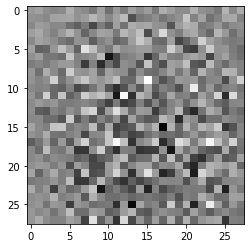

In [0]:
# 미훈련된 생성자 이용 이미지 생성
generator = make_generator_model()
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [0]:
# 감별자 
# CNN 기반의 이미지 분류
def make_discriminator_model():
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                          input_shape=[28, 28, 1]))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(1))

  return model

In [0]:
# 미훈련된 감별자 사용, 생성 이미지가 진짠지 가짠지 판별
# 진짜 이미지에는 양수(positive value), 가짜 이미지에는 음수(negative value) 출력하도록 훈련

discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[-0.00161434]], shape=(1, 1), dtype=float32)


In [0]:
# 손실 함수와 옵티마이저 정의
# cross_entropy loss를 계산하기 위해 헬퍼(helper) 함수 반환
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# 감별자 손실 함수 </br>
˙ 감별자가 가짜 이미지에서 얼마나 진짜를 잘 판별하는지 수치화 </br>
˙ 진짜 이미지에 대한 감별자의 예측과 1로 이루어진 행렬을 비교하고, 가짜 이미지에 대한 감별자의 예측과 0으로 이루어진 행렬 비교

In [0]:
def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

# 생성자 손실 함수 </br>
˙ 감별자를 얼마나 잘 속였는지 수치화 </br>
˙ 생성자가 run well 이면 감별자는 가자를 진짜(1)로 분류하겠죠? </br>
=> 그러니까 가짜 이미지에 대한 감별의 결정을 1로 이루어진 행렬과 비교

In [0]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [0]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [0]:
# 체크 포인트 저장
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [0]:
# 훈련 루프 정의
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16
# 생성자가 입력으로 랜덤 시드를 받음
# 이 시드 값 사용해서 이미지 생성
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [0]:
# 감별자를 사용하여 (훈련 세트의) 진짜와 (생성자의) 가짜를 분류
# 각 모델의 손실을 계산하고 gradient를 사용, 생성자와 감별자를 업데이트
# @tf.function 데코레이터는 함수를 컴파일함
@tf.function
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE, noise_dim])
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
  

In [0]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # GIF를 위한 이미지 생성
    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch + 1, seed)

    # 15 epoch마다 모델 저장
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    # print(' 에포크 {}에서 걸린 시간은 {}초 입니다'.format(epoch +1, time.time() -start))

  # 마지막 에포크가 끝난 후 생성
  display.clear_output(wait=True)
  generate_and_save_images(generator, epochs, seed)


In [0]:
# 이미지 생성 및 저장
def generate_and_save_images(model, epoch, test_input):
  # 'training'이 False로 맞춰진 것을 주목
  # (배치정규화 포함) 모든 층들이 추론 모드로 실행
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

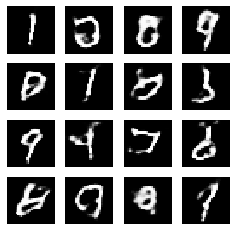

CPU times: user 2min 6s, sys: 27.2 s, total: 2min 33s
Wall time: 11min 2s


In [0]:
# 모델 훈련
# train()을 생성자와 감별자를 동시에 훈련하기 위해 호출
# 생성자와 감별자가 서로를 제압하지 않아야함, 학습률이 비슷하면 한 쪽이 
# 우세해짐

%%time
train(train_dataset, EPOCHS)

In [0]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [0]:
# gif 생성
# 에포크 숫자를 사용하여 하나의 이미지를 보여줌
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

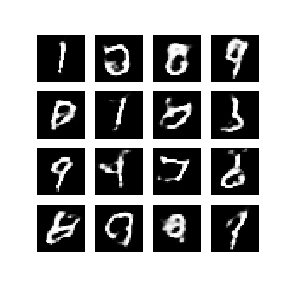

In [0]:
display_image(EPOCHS)

In [0]:
# imageio로 훈련 중 저장된 이미지 사용 gif 애니메이션 만들기
anim_file = 'dcgan.gif'
with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i, filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6, 2, 0, ''):
  display.Image(filename=anim_file)


In [0]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download(anim_file)